In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from scipy.integrate import simpson

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Improvements

- Discrete lienar reservoir
- Bound total flow by input
- Non-linear reservoir
- Physical model?

In [330]:
rain = pd.read_csv("Data/percipitation_data.csv", header= None)
rain.columns = ["Date", "Rain"]


In [331]:
# # Convert to mm
# rain["Rain"] = rain["Rain"] * 25.4

# # San Lorenzo Water District is 60 miles^2
# ha = 60 * 258.999

# # Convert to m^3
# rain["Rain"] = rain["Rain"] * ha * 10
#Inch rain over 60 sq m to cubic feet
rain["Rain"] = rain['Rain'] * 139400381



In [332]:
san_lorenzo = pd.read_csv("Data/san_lorenzo.csv")


In [333]:
#Convert to cubic meter
#san_lorenzo["Flow"] = san_lorenzo["Flow"] *  0.0283168

In [334]:
runoff_data =pd.merge(san_lorenzo, rain, on= "Date", how="inner")
runoff_data["Date"] = pd.to_datetime(runoff_data["Date"])
runoff_data

,Date,Flow,Rain
0,2016-04-06,112.0,0.000000e+00
1,2016-04-07,111.0,3.638350e+08
2,2016-04-08,106.0,4.182011e+07
3,2016-04-09,104.0,0.000000e+00
4,2016-04-10,104.0,0.000000e+00
...,...,...,...
2515,2023-02-24,558.0,1.965545e+08
2516,2023-02-25,437.0,1.394004e+06
2517,2023-02-26,439.0,1.463704e+08
2518,2023-02-27,815.0,1.394004e+08


## Linear Reservoir Model
**Flow Equation**: $Q = A \cdot S$

**Continuitity Equation**: $R = Q + \frac{dS}{dT}$

**Differential Equation**:  $Q_2 = Q_1 e^{-A(T_2 - T_1)} + R[1 - e^{-A(T_2 - T_1)}]$

Inputs: Precipitation: R(t) (inches)

Tuning Parameters: A: Response Factor: A

Output: Runoff: Q(t) (cubic feet per second)

Note that the model is intended needs to be corrected for units and made discrete

1 mm/day corresponds to 10 m3/day per ha of the watershed

### Continuous

In [208]:
## Model
def runoff(R, T2, T1, A, Q1 ):
    Q2 = Q1* np.exp(-A *(T2- T1)) + R*(1 - np.exp(-A *(T2- T1)))
    return Q2

def calc_runoff(A, runoff_data):
    runoffs = [0]
    for i in runoff_data.index:
        if i != 0:
            runoffs.append(runoff(runoff_data.Rain[i], i, i -1, A, runoffs[-1]))
    #runoff_data["Runoff"] = runoffs
    return runoffs

In [209]:
def plot_runoffs(runoff_data, runoffs, labels):
    plt.figure(figsize=(8, 6))
    plt.plot(runoff_data["Date"], runoff_data["Flow"]/max(runoff_data["Flow"]), label = "Actual")
    for i in range(len(labels)):
        plt.plot(runoff_data["Date"], runoffs[i]/max( runoffs[i]), label = "A: {}".format(labels[i]))
    plt.legend()
    plt.title("Rainflow-Runoff Model vs. Actual Flow")
    plt.show()
    

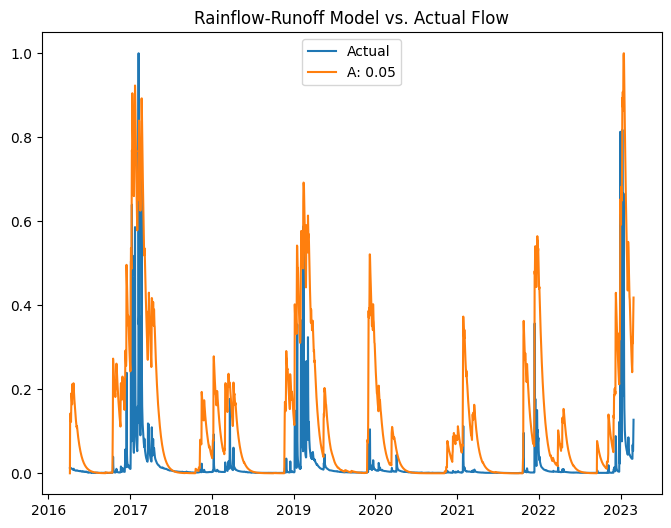

In [210]:
plot_runoffs(runoff_data, [calc_runoff(0.05, runoff_data)], [0.05])

In [221]:
runoff_data

,Date,Flow,Rain
0,2016-04-06,112.0,0.000000e+00
1,2016-04-07,111.0,3.638350e+08
2,2016-04-08,106.0,4.182011e+07
3,2016-04-09,104.0,0.000000e+00
4,2016-04-10,104.0,0.000000e+00
...,...,...,...
2515,2023-02-24,558.0,1.965545e+08
2516,2023-02-25,437.0,1.394004e+06
2517,2023-02-26,439.0,1.463704e+08
2518,2023-02-27,815.0,1.394004e+08


### Discrete Linear Reservoir Model


**Flow Equation**: $Q = A \cdot S$

**Continuitity Equation**: $R = Q + \frac{dS}{dT}$

**Differential Equation**:  $Q_2 = Q_1 e^{-A(T_2 - T_1)} + R[1 - e^{-A(T_2 - T_1)}]$

Inputs: Precipitation: R(t) (inches)

Tuning Parameters: A: Response Factor: A

Output: Runoff: Q(t) (cubic feet per second)

S is water storage

Note that the model is intended needs to be corrected for units and made discrete

1 mm/day corresponds to 10 m3/day per ha of the watershed

In [211]:
def discrete_runoff (A, Q1, R):
    runoff = [Q1]

    for r in R[1:]:
        Q2 = (A * r  + runoff[-1])/( 1+ A)
        runoff.append(Q2)
    
    return runoff


In [219]:
def plot_discrete_runoffs(runoff_data, labels):
    plt.figure(figsize=(15, 10))
    plt.plot(runoff_data["Date"], runoff_data["Flow"]/max(runoff_data.Flow), label = "Actual, {}".format(sum(runoff_data["Flow"]/max(runoff_data.Flow))))
    plt.plot(runoff_data["Date"], np.cumsum(runoff_data["Flow"])/sum(runoff_data.Flow) )
    for i in range(len(labels)):
        runoff = discrete_runoff(labels[i], runoff_data["Flow"][0], runoff_data["Rain"])
        plt.plot(runoff_data["Date"], runoff/max(runoff) + 1 * (i+1), label = "A: {}".format(labels[i]))
        plt.plot(runoff_data["Date"], np.cumsum(runoff)/sum(runoff) + 1 * (i+1))

    plt.legend()
    plt.title("Discrete Rainflow-Runoff Model vs. Actual Flow")
    plt.show()
    


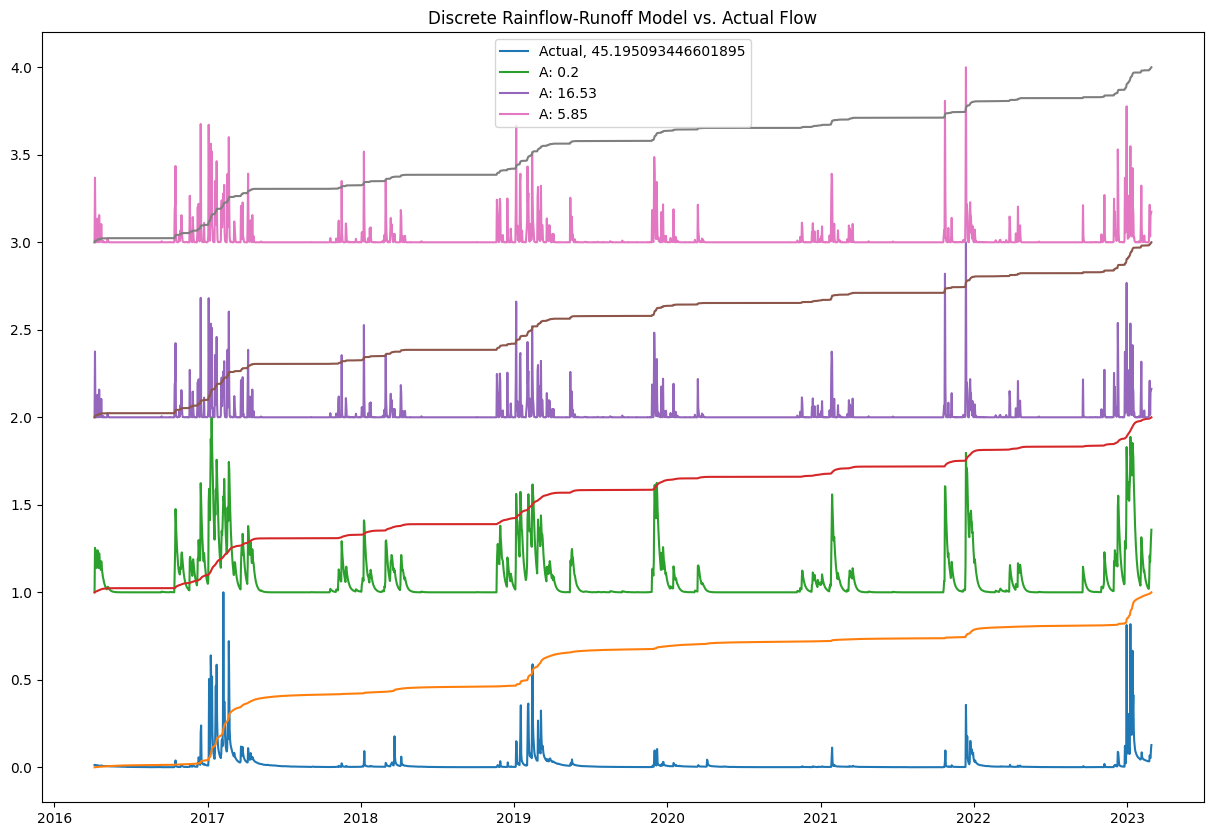

In [291]:
plot_discrete_runoffs(runoff_data, [0.2, 16.53, 5.85])

### Integration Optimization

In [279]:
def optimal_discrete_integration (runoff_data, As, n):
    scores = []
    #actual = runoff_data["Flow"]
    act_vol = []
    actual_sub = np.array_split(runoff_data["Flow"]/max(runoff_data["Flow"]), n)
    for i in actual_sub:
        act_vol.append(simpson(i))
    #print(act_vol)
    
    for A in As:
        runoff = discrete_runoff(A, runoff_data["Flow"][0], runoff_data["Rain"])
        runoff_sub = np.array_split(runoff/max(runoff), n)
        trial_vol = []
        for j in runoff_sub:
            trial_vol.append( simpson(j))

        #yeet = np.array(act_vol) - np.array(trial_vol)
        #print(yeet)
        scores.append(sum(np.array(act_vol)- np.array(trial_vol))**2)
    
    ind = np.argmin(scores)
    #print(scores)
    plt.plot(As, scores)
    plt.axvline(As[ind], color = 'r')
    plt.show()
    return As[ind], scores[ind]

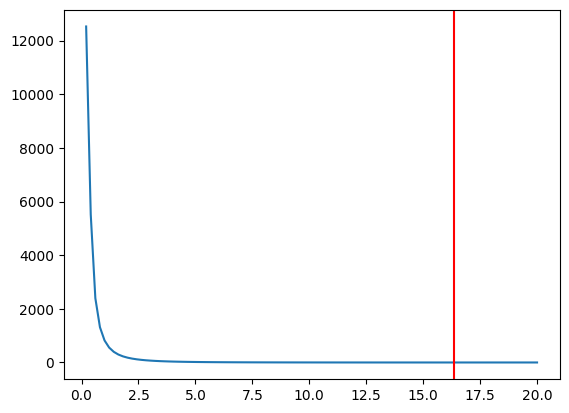

(16.363636363636363, 0.00013181843124637237)

In [286]:
optimal_discrete_integration(runoff_data, np.linspace(0,20, 100)[1:], 250)


### CumSum Optimization

In [289]:
def optimal_discrete_cumsum (runoff_data, As):
    scores = []
    #actual = runoff_data["Flow"]
    act_vol = []
    actual_cumsum = np.cumsum(runoff_data["Flow"]/max(runoff_data["Flow"]))
    
    #print(act_vol)
    
    for A in As:
        runoff = discrete_runoff(A, runoff_data["Flow"][0], runoff_data["Rain"])
        runoff_cumsum = np.cumsum(runoff/max(runoff))
    
        scores.append(sum(np.array(actual_cumsum)- np.array(runoff_cumsum))**2)
    
    ind = np.argmin(scores)
    #print(scores)
    plt.plot(As, scores)
    plt.axvline(As[ind], color = 'r')
    plt.show()
    return As[ind], scores[ind]

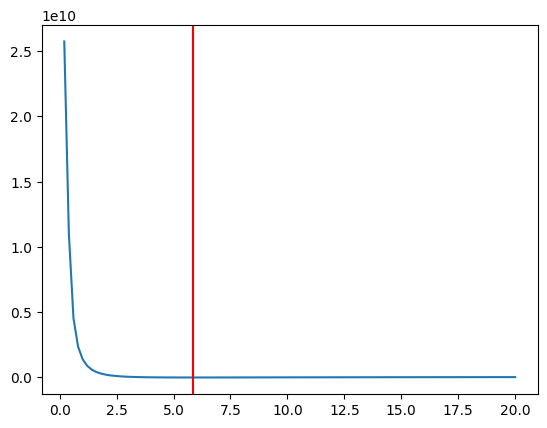

(5.858585858585858, 11066.886865044022)

In [290]:
optimal_discrete_cumsum(runoff_data, np.linspace(0,20, 100)[1:])

### Optimal A

In [64]:
def accuracy_score(actual, model):
    model_diff = np.diff(model)
    model_diff = model_diff / max(model_diff)

    actual_diff = np.diff(actual)
    actual_diff = actual_diff / max(actual_diff)

    score = sum((actual_diff - model_diff)**2)

    return score

In [89]:
def optimal_discrete_response (runoff_data, As):
    scores = []
    actual = runoff_data["Flow"]

    for A in As:
        runoff = discrete_runoff(A, runoff_data["Flow"][0], runoff_data["Rain"])
        scores.append(accuracy_score(actual, runoff))
    
    ind = np.argmin(scores)

    return As[ind], scores[ind]


In [90]:
optimal_discrete_response(runoff_data, np.linspace(0,0.5,100)[1:])

(0.2070707070707071, 10.9650270508607)

### Lin Interp Check

In [357]:
A = 5
runoff_data["Discrete"] = discrete_runoff(A, runoff_data["Flow"][0], runoff_data["Rain"])
runoff_data

,Date,Flow,Rain,Discrete
0,2016-04-06,112.0,0.000000e+00,1.120000e+02
1,2016-04-07,111.0,3.638350e+08,3.031958e+08
2,2016-04-08,106.0,4.182011e+07,8.538274e+07
3,2016-04-09,104.0,0.000000e+00,1.423046e+07
4,2016-04-10,104.0,0.000000e+00,2.371743e+06
...,...,...,...,...
2515,2023-02-24,558.0,1.965545e+08,1.778323e+08
2516,2023-02-25,437.0,1.394004e+06,3.080039e+07
2517,2023-02-26,439.0,1.463704e+08,1.271087e+08
2518,2023-02-27,815.0,1.394004e+08,1.373518e+08


In [358]:
new = runoff_data["Date"].diff()/2 + runoff_data["Date"]

In [359]:
runoff_interp = runoff_data.copy()
for i in new:
    runoff_interp.loc[i] = [i, "", "", ""]

In [360]:
runoff_interp = runoff_interp.reset_index().drop(["index"], axis = 1).sort_values("Date")


In [361]:
runoff_interp

,Date,Flow,Rain,Discrete
0,2016-04-06 00:00:00,112.0,0.0,112.0
1,2016-04-07 00:00:00,111.0,363834994.41,303195847.341667
2521,2016-04-07 12:00:00,NaN,NaN,NaN
2,2016-04-08 00:00:00,106.0,41820114.3,85382736.473611
2522,2016-04-08 12:00:00,NaN,NaN,NaN
...,...,...,...,...
2518,2023-02-27 00:00:00,815.0,139400381.0,137351772.648935
5038,2023-02-27 12:00:00,NaN,NaN,NaN
2519,2023-02-28 00:00:00,1050.0,149158407.67,147190635.166489
5039,2023-02-28 12:00:00,NaN,NaN,NaN


In [362]:
runoff_interp["Flow"] = pd.to_numeric(runoff_interp["Flow"], errors ="coerce")
runoff_interp["Discrete"] = pd.to_numeric(runoff_interp["Discrete"], errors ="coerce")

In [365]:
runoff_interp = runoff_interp.interpolate()

In [367]:
runoff_interp

,Date,Flow,Rain,Discrete
0,2016-04-06 00:00:00,112.0,0.0,1.120000e+02
1,2016-04-07 00:00:00,111.0,363834994.41,3.031958e+08
2521,2016-04-07 12:00:00,108.5,NaN,1.942893e+08
2,2016-04-08 00:00:00,106.0,41820114.3,8.538274e+07
2522,2016-04-08 12:00:00,105.0,NaN,4.980660e+07
...,...,...,...,...
2518,2023-02-27 00:00:00,815.0,139400381.0,1.373518e+08
5038,2023-02-27 12:00:00,932.5,NaN,1.422712e+08
2519,2023-02-28 00:00:00,1050.0,149158407.67,1.471906e+08
5039,2023-02-28 12:00:00,1050.0,NaN,1.471906e+08


In [368]:
simpson(runoff_interp["Discrete"])

82110627392.80751

In [369]:
simpson(runoff_data["Discrete"])

40995735301.50214

## Non-Linear Reservoir

In [168]:
def step_response (Q, A1 = 0.1, A2= 0.2, A3 = 0.5):
    if Q < 0.25:
        return A1
    elif Q < 0.5:
        return A2
    else:
        return A3

def linear_response (Q, m= 1, b= 0):
    return m*Q + b

def exponential_response (Q, B = 1):
    return np.exp(B * Q)

def logistic_response (Q, B =1 ):
    return 1/ (1 + np.exp(-B * Q))

In [169]:
def non_linear_discrete_runoff (Q1, R, get_A, args):
    runoff = [Q1]
    #print(args)
    
    for r in R[1:]:
        yeet = (runoff[-1]/max(runoff),) + args
        #print(yeet)
        A = get_A(*yeet)
        Q2 = (A * r  + runoff[-1])/( 1+ A)
        runoff.append(Q2)
    
    return runoff

In [ ]:
non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],linear_response, (3 ,2) )

In [ ]:
plt.figure(figsize=(8, 6))
    plt.plot(runoff_data["Date"], runoff_data["Flow"]/max(runoff_data.Flow), label = "Actual")
    print(*args)

    runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],function, (0.01, )) )
    plt.plot(runoff_data["Date"], runoff/max(runoff), label = "Non-Linear Model")

    plt.legend()
    plt.title("Discrete Non-Linear Rainflow-Runoff Model vs. Actual Flow")
    plt.show()

In [172]:
def plot_non_linear_discrete_runoffs(runoff_data, function, args):
    plt.figure(figsize=(8, 6))
    plt.plot(runoff_data["Date"], runoff_data["Flow"]/max(runoff_data.Flow), label = "Actual")
    print(*args)

    runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],function, *args )
    plt.plot(runoff_data["Date"], runoff/max(runoff), label = "Non-Linear Model")

    plt.legend()
    plt.title("Discrete Non-Linear Rainflow-Runoff Model vs. Actual Flow")
    plt.show()

0.01 0.2 0.5


TypeError: non_linear_discrete_runoff() takes 4 positional arguments but 6 were given

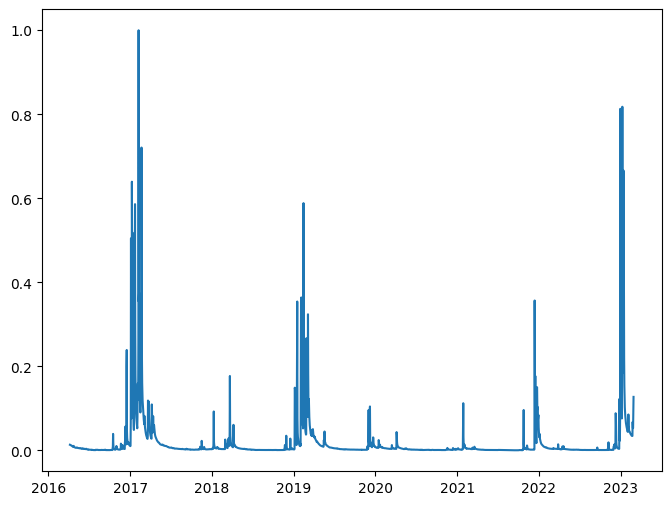

In [179]:
plot_non_linear_discrete_runoffs(runoff_data, step_response, (0.01, 0.2, 0.5))

### Optimal Values

#### Step Response

In [156]:
n = 10
A1s = np.linspace(0,1, n)[1:]
A2s = np.linspace(0,1, n)[1:]
A3s = np.linspace(0,1, n)[1:]

params = itertools.product(A1s, A2s, A3s)

min_score = 100000
min_arg = [0,0,0]
for vals in tqdm(params):
    #print(vals)
    runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],step_response, vals)
    new_score = accuracy_score(runoff_data["Flow"],runoff)

    if new_score < min_score:
        min_score = new_score
        min_arg = vals

min_score
min_arg

729it [00:49, 14.65it/s]


(0.2222222222222222, 1.0, 0.8888888888888888)

In [ ]:
plot_non_linear_discrete_runoffs(runoff_data, step_response, min_arg)

#### Linear Response

In [158]:
n = 25

ms= np.linspace(0,10, n)[1:]
bs = np.linspace(0,0.5, n)[1:]

params = itertools.product(ms, bs)

min_score = 100000
min_arg = [0,0,0]
for vals in tqdm(params):
    #print(vals)
    runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],linear_response, vals)
    new_score = accuracy_score(runoff_data["Flow"],runoff)

    if new_score < min_score:
        min_score = new_score
        min_arg = vals

min_score
min_arg

576it [00:37, 15.40it/s]


(1.25, 0.020833333333333332)

In [165]:
(min_arg)

(1.25, 0.020833333333333332)

TypeError: non_linear_discrete_runoff() takes 4 positional arguments but 5 were given

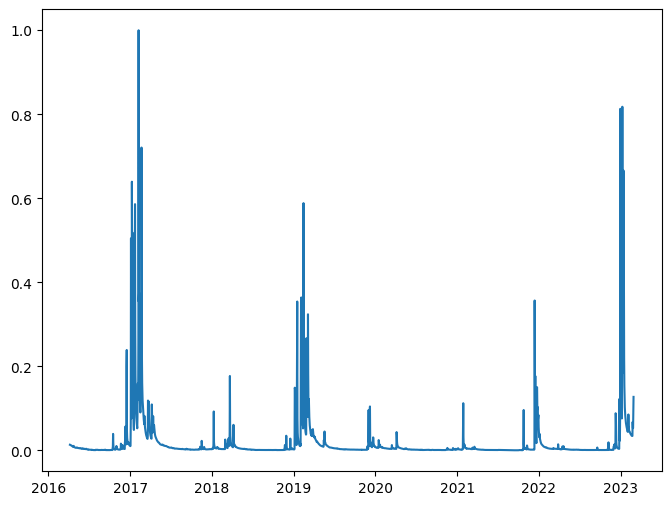

In [167]:
plot_non_linear_discrete_runoffs(runoff_data, linear_response, (1, 0))

TypeError: non_linear_discrete_runoff() takes 4 positional arguments but 5 were given

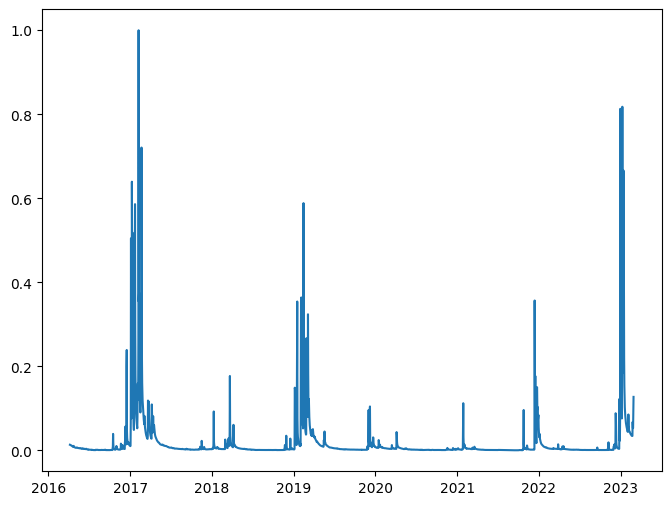

In [166]:
plot_non_linear_discrete_runoffs(runoff_data, linear_response, (min_arg))

#### Exponential Response

In [ ]:
n = 25
ms= np.linspace(0,10, n)[1:]
bs = np.linspace(0,0.5, n)[1:]



params = itertools.product(ms, bs)

min_score = 100000
min_arg = [0,0,0]
for vals in tqdm(params):
    #print(vals)
    runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],exponential_response, vals)
    new_score = accuracy_score(runoff_data["Flow"],runoff)

    if new_score < min_score:
        min_score = new_score
        min_arg = vals

min_score
min_arg

In [ ]:
plot_non_linear_discrete_runoffs(runoff_data, exponential_response, min_arg)

#### Logistic Response

In [ ]:
n = 25
ms= np.linspace(0,10, n)[1:]
bs = np.linspace(0,0.5, n)[1:]



params = itertools.product(ms, bs)

min_score = 100000
min_arg = [0,0,0]
for vals in tqdm(params):
    #print(vals)
    runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"],logistic_response, vals)
    new_score = accuracy_score(runoff_data["Flow"],runoff)

    if new_score < min_score:
        min_score = new_score
        min_arg = vals

min_score
min_arg

In [ ]:
plot_non_linear_discrete_runoffs(runoff_data, logistic_response, min_arg)

# Applying to VIX

In [93]:
non_linear_runoff = non_linear_discrete_runoff(runoff_data["Flow"][0], runoff_data["Rain"])
accuracy_score(runoff_data["Flow"],non_linear_runoff )

10.143914261030103